In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import geopandas as gpd

# To address problem with current windows build of GeoPandas
# https://github.com/geopandas/geopandas/issues/830
import os
os.environ["PROJ_LIB"] = "C:\ProgramData\Anaconda3\Library\share" #windows

Our biggest challenge is automating the combination of police data, census-level data, and other socioeconomic factors. Shapefiles are unusual and messy -- which makes it difficult to, for instance, generate maps of police behavior with precinct boundary layers mixed with census layers. Police incident data are also very difficult to normalize and standardize across departments since there are no federal standards for data collection..

Main Prize Track submissions will be judged based on the following general criteria:

Performance - How well does the solution combine shapefiles and census data? How much manual effort is needed? CPE will not be able to live-test every submission, so a strong entry will be able to automate using shape files with different projections and clearly articulate why it is effective at tackling the problem.

Accuracy - Does the solution provide reliable and accurate analysis? How well does it match census-level demographics to police deployment areas?

Approachability - The best solutions should use best coding practices and have useful comments. Plots and graphs should should be self-explanatory. CPE might use your work to explain to stakeholders where to take action,so the results of your solution should be developed for an audience of law enforcement professionals and public officials.

In [ ]:
# Find file locations
import os
os.listdir("../input/")

In [2]:
#Read in law enforcement agency (LEA) shapefile and check projection
#lea_shape = gpd.read_file("../input/data-science-for-good/cpe-data/Dept_49-00081/49-00081_Shapefiles/SFPD_geo_export_8a7e3c3b-8d43-4359-bebe-b7ef6a6e21f3.shp")
lea_shape = gpd.read_file("./Dept_49-00081/49-00081_Shapefiles/SFPD_geo_export_8a7e3c3b-8d43-4359-bebe-b7ef6a6e21f3.shp")
print(lea_shape.crs)
print(lea_shape.shape)
lea_shape.head()

{'init': 'epsg:4326'}
(10, 6)


,company,district,shape_area,shape_le_1,shape_leng,geometry
0,B,SOUTHERN,9.134414e+07,100231.353916,87550.275142,(POLYGON ((-122.3918613881226 37.7942468097054...
1,C,BAYVIEW,2.013846e+08,144143.480351,163013.798332,POLYGON ((-122.3809828136006 37.76480022019017...
2,D,MISSION,8.062384e+07,40518.834235,40152.783389,"POLYGON ((-122.4095391743523 37.769317718404, ..."
3,E,NORTHERN,8.278169e+07,50608.310321,56493.858208,POLYGON ((-122.4337921715291 37.80793010706978...
4,J,TENDERLOIN,1.107215e+07,18796.784185,12424.268969,"POLYGON ((-122.4021713308171 37.7862601311238,..."


The LEA shapefile for San Francisco has 10 rows (identified as police districts) and 6 columns. The projection is espg: 4326.

In [3]:
# Read in shape file for census tracts for the state. This file can be accessed directly from the Census Bureau via URL. 
# Tract maps for counties are also available, but some police departments might span counties (e.g., NYC).
#state_shape = gpd.read_file("../input/census-tracts-ca-2017-500k/cb_2017_06_tract_500k.shp")
state_shape = gpd.read_file("./cb_2017_06_tract_500k/cb_2017_06_tract_500k.shp")

print(state_shape.crs)
print(state_shape.shape)
state_shape.head()

{'init': 'epsg:4269'}
(8041, 10)


,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,06,001,400600,1400000US06001400600,06001400600,4006,CT,297856,0,"POLYGON ((-122.26807 37.844136, -122.26514 37...."
1,06,001,400900,1400000US06001400900,06001400900,4009,CT,420877,0,"POLYGON ((-122.285576 37.839778, -122.283186 3..."
2,06,001,401400,1400000US06001401400,06001401400,4014,CT,758204,0,"POLYGON ((-122.278611 37.826878, -122.268563 3..."
3,06,001,403000,1400000US06001403000,06001403000,4030,CT,352394,0,"POLYGON ((-122.274757 37.79883299999999, -122...."
4,06,001,405902,1400000US06001405902,06001405902,4059.02,CT,487280,0,"POLYGON ((-122.247175 37.789913, -122.243512 3..."


The tract shapefile for California has 8041 rows and 10 columns. The unique tract identifier is the combination of the state FIPS code (STATEFP), the county FIPS code (COUNTYFP), and the tract (TRACTCE). The projection is espg: 4269.

In [4]:
# Convert LEA geometry to same projection as Census files
lea_shape = lea_shape.to_crs({'init': 'epsg:4269'}) 

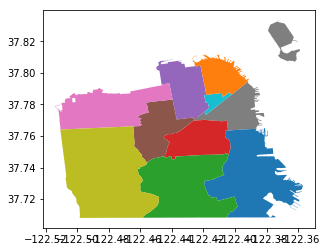

In [5]:
# Quick plot shows the 10 police districts
lea_shape.plot(column = 'district')

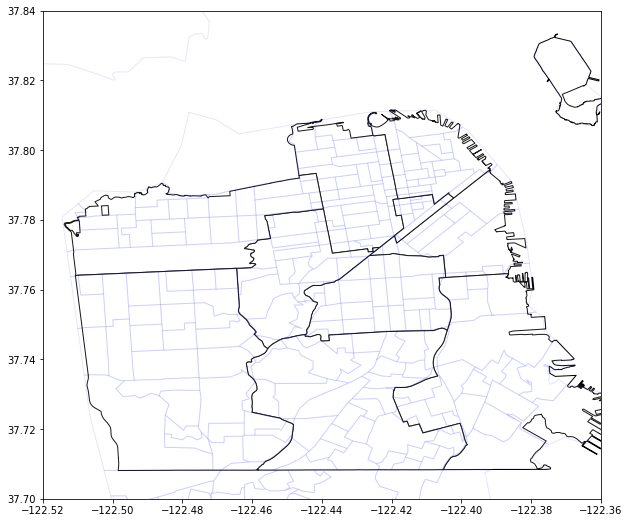

In [9]:
# Plot both LEA districts and census tracts together

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10, 10, forward=True)

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')
ax.set_xlim(-122.52, -122.36)
ax.set_ylim(37.7, 37.84)

lea_shape.plot(ax=ax, color='white', edgecolor='black')
state_shape.plot(ax=ax, color='white', edgecolor='blue', alpha=.1)
plt.show();

#### Above we see that in general there are many census tracts per LEA district. Sometimes the boundaries coincide, but some tracts are split between two police divisions. Next we will create an intersection using these shapes that will allow us to convert demographic and social data at the census tract level to the LEA district level. 

In [10]:
# Create new Geodataframe that contains the intersections
intersect = gpd.overlay(state_shape, lea_shape, how='intersection')

In [11]:
intersect.TRACTCE.value_counts().head()

016801    4
030600    3
061500    3
016802    3
017700    3
Name: TRACTCE, dtype: int64

#### Notice that because some tracts intersect with multiple LEA districts, they have been split into smaller polygons.

In [12]:
# Select tract that has been split into 4 parts
tract_new = intersect[intersect['TRACTCE'] == "016801"]

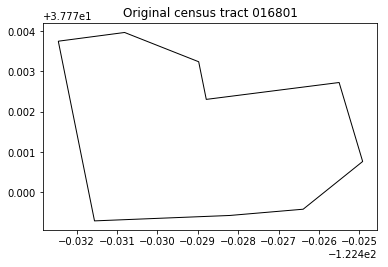

In [13]:
# Show shape of original tract
tract_old = state_shape[state_shape['TRACTCE'] == "016801"]
fig, ax = plt.subplots()
ax.set_title("Original census tract 016801")
tract_old.plot(ax=ax, color='white', edgecolor='black')


Text(0.5,1,'Intersection of census tract with LEA districts')

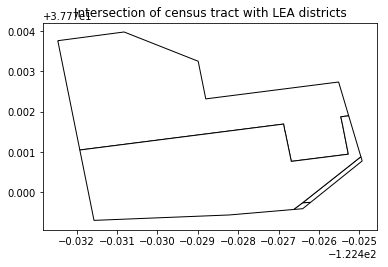

In [14]:
# Show tract split by intersection
fig, ax = plt.subplots()
tract_new.plot(ax=ax, color='white', edgecolor='black')
ax.set_title("Intersection of census tract with LEA districts")

#### The above plot shows how this census tract has been split into 4 parts by the intersection. Next we will use these new polygons to transform census tract-level data to LEA district-level. The first step is to calculate some areas.



In [15]:
# Area of intersection polygons (and drop unneeded columns)
intersect['inter_area'] = intersect.area
intersect = intersect.drop(columns = ['ALAND', 'AWATER', 'shape_area', 'shape_le_1', 'shape_leng'])

In [ ]:
#intersect.groupby('TRACTCE')['inter_area'].sum()

In [ ]:
#intersect.groupby('TRACTCE')['inter_area'].sum().transform(lambda x: x/x.sum())

In [24]:
tract_area = intersect.groupby("TRACTCE").agg({'inter_area': 'sum'})
tract_area.rename(index=str, columns={"inter_area": "tract_area"}, inplace=True)
tract_area.head()

,tract_area
TRACTCE,
010100,0.000078
010200,0.000053
010300,0.000028
010400,0.000034
010500,0.000071


In [23]:
LEA_area = intersect.groupby("TRACTCE").agg({'inter_area': 'sum'})
LEA_area.rename(index=str, columns={"inter_area": "LEA_area"}, inplace=True)
LEA_area.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199 entries, 010100 to 980900
Data columns (total 1 columns):
LEA_area    199 non-null float64
dtypes: float64(1)
memory usage: 3.1+ KB


In [17]:
intersect2 = intersect.merge(tract_area, how='left', on='TRACTCE')

In [18]:
intersect2.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,company,district,geometry,inter_area_x,inter_area_y
0,06,075,010200,1400000US06075010200,06075010200,102,CT,E,NORTHERN,POLYGON ((-122.4209947732141 37.79988783063619...,0.000015,0.000053
1,06,075,015900,1400000US06075015900,06075015900,159,CT,E,NORTHERN,"POLYGON ((-122.434562 37.784152, -122.431291 3...",0.000030,0.000030
2,06,075,016300,1400000US06075016300,06075016300,163,CT,E,NORTHERN,"POLYGON ((-122.433219 37.77749, -122.429929 37...",0.000025,0.000025
3,06,075,012402,1400000US06075012402,06075012402,124.02,CT,E,NORTHERN,"POLYGON ((-122.421069 37.783816, -122.41924358...",0.000021,0.000037
4,06,075,016400,1400000US06075016400,06075016400,164,CT,E,NORTHERN,POLYGON ((-122.4382836857813 37.77684294752537...,0.000019,0.000032


In [25]:
# Select tract that has been split into 4 parts
check = intersect2[intersect2['TRACTCE'] == "016801"]
check

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,company,district,geometry,inter_area_x,inter_area_y
5,06,075,016801,1400000US06075016801,06075016801,168.01,CT,E,NORTHERN,"POLYGON ((-122.432467 37.773757, -122.430825 3...",1.260055e-05,0.000024
103,06,075,016801,1400000US06075016801,06075016801,168.01,CT,D,MISSION,POLYGON ((-122.4262059337735 37.76975333216542...,3.115947e-08,0.000024
138,06,075,016801,1400000US06075016801,06075016801,168.01,CT,B,SOUTHERN,"POLYGON ((-122.4249605899965 37.7708839863347,...",1.884077e-07,0.000024
264,06,075,016801,1400000US06075016801,06075016801,168.01,CT,F,PARK,POLYGON ((-122.4252626552533 37.77189743340575...,1.132829e-05,0.000024


In [ ]:
tract_groups = intersect.groupby("TRACTCE")
intersect['inter_area'].tract_groups['inter_area'].sum()

But first we have to get some census tract data. For now, we will just grab the total population estimate to use as a demonstration. Later we will look at census data more in-depth.


Outside of the decennial census, the primary source for census data at the geographic level of the census tract or lower is the 5-year American Community Survey data. The 5 year ACS is a rich source of data. Tables are available containing many detailed breakdowns, and the full range of long-form census questions are included. The tradeoff, however, is that this data represents an overall 5-year period. So, for example, the 2017 ACS 5-year data is reflective of the period 2013-2017. Updated 5-year tables are released each year, but they are not intended to be used as moving averages.  The 5-year window allows the Census Bureau to protect individual privacy while managing a large scale survey research process. The names of the data files provided for this challenge indicate that the data is from the 2015 5yr ACS release, which covers the years 2011-2015.

In [ ]:
# Read in demographics table


In [ ]:
tracts = state_shape['geometry'].intersection(lea_shape)

In [ ]:
#This should bring in basemaps for context, but I can't get the package imported on Kaggle
#import contextily as ctx

#def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

In [ ]:
from shapely.geometry import Polygon

polys1 = gpd.GeoSeries([Polygon([(0,0), (2,0), (2,2), (0,2)]),
                              Polygon([(2,2), (4,2), (4,4), (2,4)])])


polys2 = gpd.GeoSeries([Polygon([(1,1), (3,1), (3,3), (1,3)]),
                              Polygon([(3,3), (5,3), (5,5), (3,5)])])

df1 = gpd.GeoDataFrame({'geometry': polys1, 'df1':[1,2]})

df2 = gpd.GeoDataFrame({'geometry': polys2, 'df2':[1,2]})

In [ ]:
ax = df1.plot(color='red');

df2.plot(ax=ax, color='green', alpha=0.5);

In [ ]:
subset = gpd.overlay(df2, df1, how='intersection')

In [ ]:
subset.plot()

In [ ]:
subset